# MuTraff - Analyze Single Experiment
Takes a single experiment results files and makes analitical diagnosis.
Use files: edge_stats.csv

In [1]:

%matplotlib inline

import os
import re
import pprint as pp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib.cm import get_cmap

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

#plt.style.use('ggplot')

In [2]:
MUTRAFF_HOME="/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
MUTRAFF_EXP_PATH=MUTRAFF_HOME + "/experiments/tmp"
SIMUL_TIME_STATS=None
COLUMNS=[]
exp={}
label={}

SMALL_FONT_SIZE=10
MID_FONT_SIZE=12
BIG_FONT_SIZE=14


## Load data from experiment file

In [3]:
def load_data(experiment):
    global MUTRAFF_EXP_PATH
    filename = "{}/{}/{}".format(MUTRAFF_EXP_PATH,experiment,"edge_stats.csv")
    print("Parsing file "+filename)
    df = pd.read_csv(filename)
    return df


## Time graph
Draw a time graph for the defined measure in time

In [4]:
# Example: 
# draw_graph( data, "Total halted vehicles", "traf_halted_veh_num", "Halted vehicles", "sum" )
def create_graph( title, measure_name, measure_label ):

    # Prepare the plot
    fig, axes = plt.subplots(figsize=(15,7))

    plt.xlabel('Simulation time', fontsize=BIG_FONT_SIZE)
    plt.ylabel(measure_label,fontsize=BIG_FONT_SIZE)

    # BLACK STYLE
    axes.spines['bottom'].set_color('0.5')
    axes.spines['top'].set_color('0.5')
    axes.spines['right'].set_color('0.5')
    axes.spines['left'].set_color('0.5')
    axes.patch.set_facecolor('0.1')
    plt.grid(b=True, which='major', color='0.2', linestyle='-')
    plt.grid(b=True, which='minor', color='0.2', linestyle='-')
    axes.tick_params(axis='x', colors='0.7', which='both')
    axes.tick_params(axis='y', colors='0.7', which='both')
    axes.yaxis.label.set_color('0.9')
    axes.xaxis.label.set_color('0.9')
    axes.margins(0.5)
    plt.title( title, color='0.7' )
    fig.patch.set_facecolor('0.15')

        
    # WHILE STYLE
    axes.spines['bottom'].set_color('0')
    axes.spines['top'].set_color('0')
    axes.spines['right'].set_color('0')
    axes.spines['left'].set_color('0')
    axes.patch.set_facecolor('1')
    plt.grid(b=True, which='major', color='0.2', linestyle='-')
    plt.grid(b=True, which='minor', color='0.2', linestyle='-')
    axes.tick_params(axis='x', colors='0.7', which='both')
    axes.tick_params(axis='y', colors='0.7', which='both')
    axes.yaxis.label.set_color('0.2')
    axes.xaxis.label.set_color('0.2')
    axes.margins(0.5)
    axes.set_xlim( xmin=0, xmax=3000 )
    plt.title( title, color='0.2' )
    fig.patch.set_facecolor('1')
    
    plt.rc('font', size=MID_FONT_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MID_FONT_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIG_FONT_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIG_FONT_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIG_FONT_SIZE)  # fontsize of the figure title
    
    return fig, axes

In [5]:
# Example: 
# draw_graph( data, "Total halted vehicles", "traf_halted_veh_num", "Halted vehicles", "sum" )
def draw_graphs( exp_list, title, measure_name, measure_label, function ):
    # exps = [ {'exp':experiment, 'data':data1}, ... ]

    # Rolling mean window size
    rolling_width=10
    flag_rolling = False

    # Prepare the plot
    fig, axes = create_graph( title, measure_name, measure_label )

    colors=[ 'red', 'green', 'blue', 'orange', 'black', 'pink', 'brown']

#--- Calculate y_min , y_max -------------------------
#    ax_y_min, ax_y_max = 1000, -1000
#    for item in df_list:
#        min, max = np.min(item['data']), np.max(item['data'])
#        if min < ax_y_min:
#            ax_y_min = min
#        if max > ax_y_max:
#            ax_y_max = max
#    axes.set_ylim(ax_y_min,ax_y_max])
#----------------------------------------------------
    my_handles = []
    
    color_idx = 0
    for exp in exp_list:
        df = exp['data']
        if ( function == "sum" ):
            ds  = df.groupby(['time']).sum().unstack()[measure_name]
            if flag_rolling:
                ds_rolling=df.groupby(['time']).rolling(rolling_width).sum().unstack()[measure_name]
        if ( function == "count" ):
            ds = df.groupby(['time']).count().unstack()[measure_name]
            if flag_rolling:
                ds_rolling=df.groupby(['time']).rolling(rolling_width).count().unstack()[measure_name]
                #ds = exp[exp[measure_name]>0 ].groupby(['time']).count().unstack()[measure_name]
        if ( function == "mean" ):
            ds = df.groupby(['time']).mean().unstack()[measure_name]
            if flag_rolling:
                ds_rolling=df.groupby(['time']).rolling(rolling_width).mean().unstack()[measure_name]
    
        # Draw
        my_handles.append( mpatches.Patch(color=colors[color_idx], label=exp['label']))
        ax1 = ds.plot(ax=axes, color=colors[color_idx])
        color_idx=color_idx+1
        # ax1 = ds.plot(ax=axes,color="blue")
        # ds_rolling.plot(ax=ax1,color="red")
        
    axes.legend(handles=my_handles, loc='lower center', fancybox=True, framealpha=0.5, fontsize=BIG_FONT_SIZE)
    # plt.rc('legend', fontsize=30)
    #params = {'legend.fontsize': 12, 'legend.handlelength': 2}
    #plt.rcParams.update(params)



##  Analyze experiment

In [6]:
def analyze_experiments( exp_list ):
    # display(HTML("<h2>Experiments results for {}</h2>".format(exp_list)))
    display(HTML("<h2>Experiments results</h2>"))
    display(HTML("<style>div.output_subarea table {font-size: 10px;}</style>"))
    # print( "Columnas disponibles {}".format(df.columns) )
    
    draw_graphs( exps, "Total halted vehicles", "traf_halted_veh_num", "Halted vehicles", "sum" )
    draw_graphs( exps, "Mean speed", "traf_av_speed", "Mean speed", "mean" )
    
    exp_list_1 = []
    for item in exp_list:
        df=item['data']
        exp_list_1.append( { 'exp':item['exp'], 'data':df[df["traf_halted_veh_num"]>0 ], 'label':item['label'] } )
    # exps1 = [ {'exp':exp_name, 'data':df[df["traf_halted_veh_num"]>0 ]} ]
    draw_graphs( exp_list_1, "Number of congested edges", "traf_halted_veh_num", "Number of edges", "count" )


## Experiments

In [7]:
exp[0]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_11_190508_003728"


exp[2200]="alcalahenares_M3h_nomaps_tele60_timeALL_fulltraffic_190510_235642"
exp[2201]="alcalahenares_M3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190511_163910"

exp[2300]="alcalahenares_L3h_nomaps_tele60_timeALL_fulltraffic_190515_130939"
exp[2301]="alcalahenares_L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_133434"

exp[2400]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_150939"
exp[2401]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_161514"

exp[2410]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_182031"
exp[2411]="alcalahenares_2L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190515_191357"
exp[2412]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_200544"

exp[2420]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_202233"
exp[2421]="alcalahenares_2L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190515_205714"
exp[2422]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_212938"

exp[2430]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_190516_084853"
exp[2431]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_01_190521_091537"
exp[2432]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit20_01_190521_143019"
exp[2433]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190516_091540"
exp[2434]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit100_01_190521_210550"

exp[2441]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_01_190521_213112"
exp[2442]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_01_190521_220448"
exp[2443]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190516_114311"
exp[2444]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit100_01_190521_223020"


label[2430]="Alcala 3L - No TWM"
label[2431]="Alcala 3L - TWM[8]  - uniform(5) - 10% usage"
label[2432]="Alcala 3L - TWM[8]  - uniform(5) - 20% usage"
label[2433]="Alcala 3L - TWM[8]  - uniform(5) - 50% usage"
label[2434]="Alcala 3L - TWM[8]  - uniform(5) - 100% usage"
label[2441]="Alcala 3L - TWM[16] - uniform(5) - 10% usage"
label[2442]="Alcala 3L - TWM[16] - uniform(5) - 20% usage"
label[2443]="Alcala 3L - TWM[16] - uniform(5) - 50% usage"
label[2444]="Alcala 3L - TWM[16] - uniform(5) - 100% usage"



In [30]:

# Extra-Small para no saturar y 8 mapas random (500 + 4x200)
exp[20]="XS_grid16_noBastra_reference_fulltraffic_170130_225044"
exp[21]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
exp[22]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_170130_225435"

exp[23]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit05_161115_092039"
exp[24]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
exp[25]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit20_161115_092738"
exp[26]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093115"
exp[27]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093432"

exp[28]="XS_grid16_noBastra_reference_fulltraffic_incident_190603_230928"
exp[29]="XS_grid16_noBastra_reference_fulltraffic_incident_190603_231705"
exp[29]="XS_grid16_noBastra_reference_fulltraffic_incident_190603_233544"

label[20]="Grid16 - XS - no TWM"
label[23]="Grid16 - XS - TWM[8] - normal(5) - 05% usage"
label[25]="Grid16 - XS - TWM[8] - normal(5) - 20% usage"
label[26]="Grid16 - XS - TWM[8] - normal(5) - 50% usage"
label[27]="Grid16 - XS - TWM[8] - normal(5) - 100% usage"
label[28]="Grid16 - XS - no TWM - Single incidents"
label[29]="Grid16 - XS - no TWM - Multiple incidents"

### FORESIGHT AND MAPS

In [41]:
exp[2599]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01_190605_225531"
exp[2600]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01_190607_163410"
exp[2601]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_incident_01_190605_233312"
exp[2602]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_foresight_01_190606_072936"
exp[2603]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_foresight_incident_01_190606_082447"

label[2599]="No TWM - Alcala - Taz5 to Taz50 - No foresight - Exp1"
label[2600]="No TWM - Alcala - Taz5 to Taz50 - No foresight - Exp2"
label[2601]="No TWM - Alcala - Taz5 to Taz50 - No foresight - INCIDENT"
label[2602]="No TWM - Alcala - Taz5 to Taz50 - Fore2-3-4-10"
label[2603]="No TWM - Alcala - Taz5 to Taz50 - Fore2-3-4-10 - INCIDENT"

In [45]:
exp_nums = [2430,2431,2432,2433,2434]
exp_nums = [2430,2441,2442,2443,2444]
exp_nums = [20,25,26,27]
exp_nums = [20,28,29]
exp_nums = [2600, 2601, 2602, 2603 ]

### Incidents

In [43]:
exp[2499]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_incident_190603_000953"
label[2499]="Alcala 3L - No TWM - Incident in roundabout"

exp_nums = [2430, 2500]

exp[2500]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_190604_073604"
exp[2501]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_incident_190604_082709"
exp[2502]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_01_190604_091731"

label[2500]="Alcala 3L - no TWM"
label[2501]="Alcala 3L - no TWM - Incident"
label[2502]="Alcala 3L - no TWM 16 MuTraff maps - uniform(5) - 10% usage"

exp_nums = [2500,25]

In [46]:
exps=[]
for n in exp_nums:
    if n in label:
        mylabel=label[n]
    else:
        mylabel=str(n)
    exps.append( { 'exp':exp[n], 'data': load_data(exp[n]), 'label':mylabel})

Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01_190607_163410/edge_stats.csv
Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_incident_01_190605_233312/edge_stats.csv
Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_foresight_01_190606_072936/edge_stats.csv
Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_foresight_incident_01_190606_082447/edge_stats.csv


In [47]:
exps[0]

{'exp': 'alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01_190607_163410',
 'data':         time  edge_id  traf_travel_time  traf_waiting_time  \
 0          0        0          4.122030                0.0   
 1          0        1          5.040677                0.0   
 2          0        2          5.411807                0.0   
 3          0        3         25.655868                0.0   
 4          0        4          4.825054                0.0   
 5          0        5          6.724262                0.0   
 6          0        6          2.107991                0.0   
 7          0        7          0.593233                0.0   
 8          0        8          2.450684                0.0   
 9          0        9          0.560115                0.0   
 10         0       10          2.414687                0.0   
 11         0       11          4.897048                0.0   
 12         0       12          8.177826                0.0   
 13         0       13          1.338

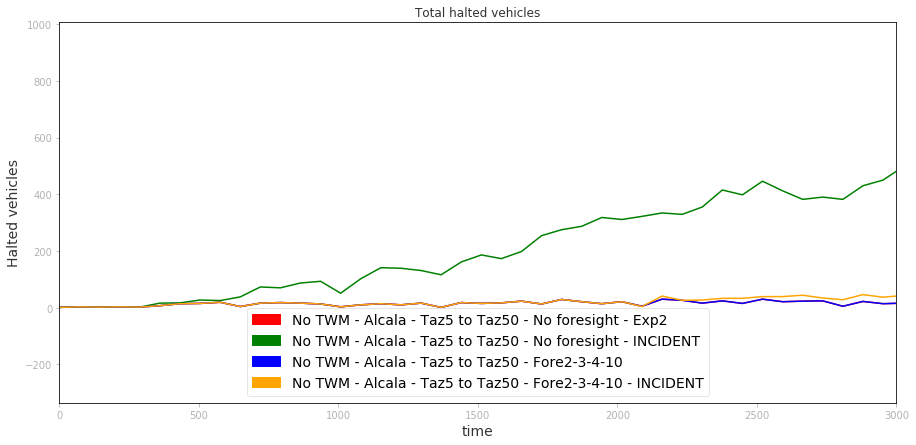

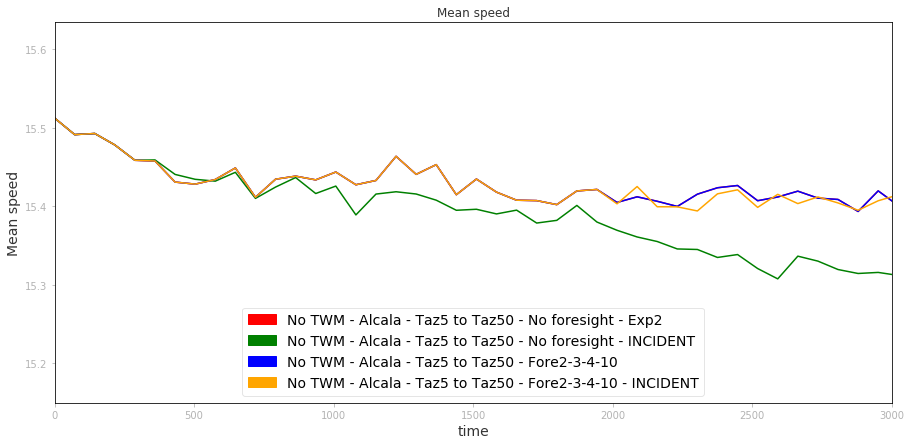

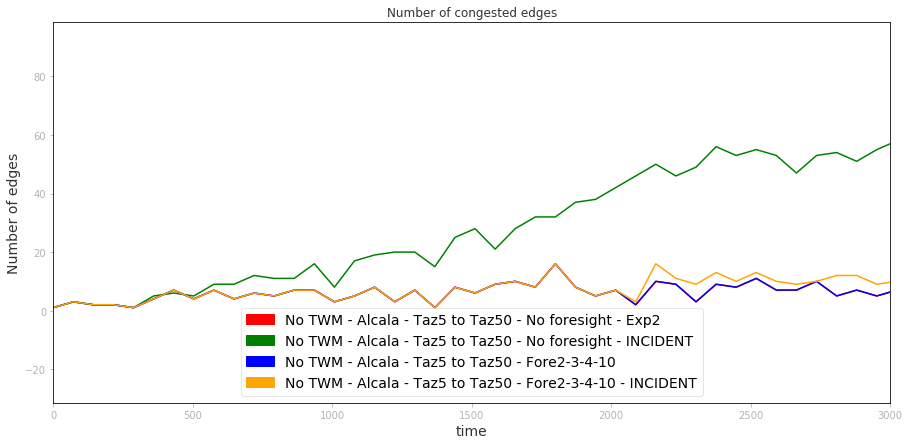

In [48]:
analyze_experiments( exps )

In [12]:
def load_experiments( exp1, exp2 ):
    data1 = load_data(exp1)
    data2 = load_data(exp2)
    exp_list = [ { "exp_names" : [exp1, exp2] },
                 { "data" : [data1, data2] }
               ]

Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_L3h_nomaps_tele60_timeALL_fulltraffic_190515_130939/edge_stats.csv
Parsing file /Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_133434/edge_stats.csv


TypeError: 'NoneType' object is not iterable

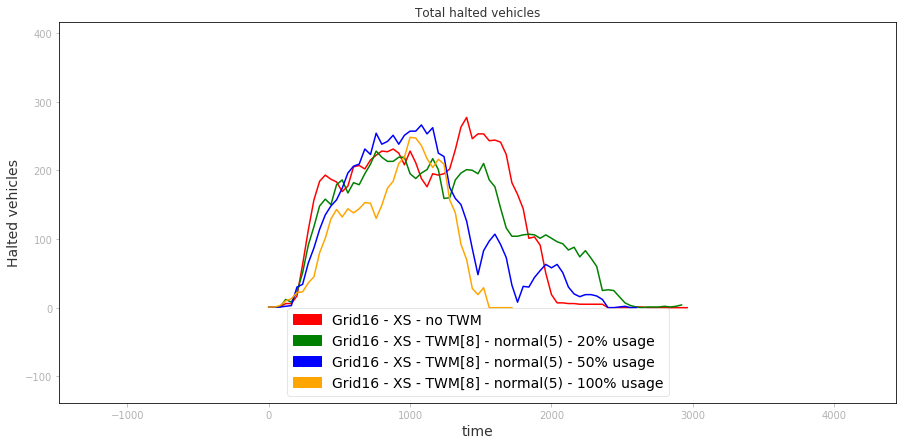

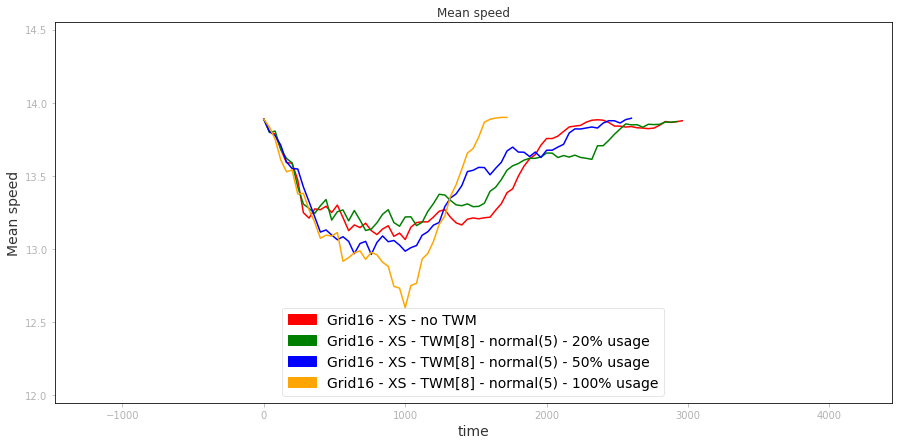

In [13]:
exp_list = load_experiments( exp[2300], exp[2301] )
analyze_experiments( exp_list )

# BACKUP

In [21]:
ds1 = data[data["traf_halted_veh_num"]>0 ]
measure_name='traf_halted_veh_num'
ds1[ds1[measure_name]>0 ].groupby(['time']).rolling(4).count()

time  edge_id  traf_travel_time  traf_waiting_time  \
time                                                              
0    5447     1.0      1.0               1.0                1.0   
25   8971     1.0      1.0               1.0                1.0   
     9657     2.0      2.0               2.0                2.0   
     13622    3.0      3.0               3.0                3.0   
50   17149    1.0      1.0               1.0                1.0   
     17718    2.0      2.0               2.0                2.0   
75   24978    1.0      1.0               1.0                1.0   
     25547    2.0      2.0               2.0                2.0   
100  33309    1.0      1.0               1.0                1.0   
     34707    2.0      2.0               2.0                2.0   
     37295    3.0      3.0               3.0                3.0   
125  39276    1.0      1.0               1.0                1.0   
     43971    2.0      2.0               2.0                2.0   
     46543    3.0      3.0               3.0                3.0   
150  48950    1.0      1.0               1.0                1.0   
     49034    2.0      2.0               2.0                2.0   
     50009    3.0      3.0               3.0                3.0   
     52945    4.0      4.0               4.0                4.0   
175  56294    1.0      1.0               1.0                1.0   
     56863    2.0      2.0               2.0                2.0   
     57947    3.0      3.0               3.0                3.0   
     59680    4.0      4.0               4.0                4.0   
     60774    4.0      4.0               4.0                4.0   
     61317    4.0      4.0               4.0                4.0   
     61559    4.0      4.0               4.0                4.0   
200  62763    1.0      1.0               1.0                1.0   
     66888    2.0      2.0               2.0                2.0   
     69388    3.0      3.0               3.0                3.0   
     69543    4.0      4.0               4.0                4.0   
225  70592    1.0      1.0               1.0                1.0   
...           ...      ...               ...                ...   
2425 760074   1.0      1.0               1.0                1.0   
     760345   2.0      2.0               2.0                2.0   
     760904   3.0      3.0               3.0                3.0   
     760968   4.0      4.0               4.0                4.0   
     761337   4.0      4.0               4.0                4.0   
     761473   4.0      4.0               4.0                4.0   
     761848   4.0      4.0               4.0                4.0   
     762557   4.0      4.0               4.0                4.0   
     764290   4.0      4.0               4.0                4.0   
     764291   4.0      4.0               4.0                4.0   
     764692   4.0      4.0               4.0                4.0   
     764833   4.0      4.0               4.0                4.0   
     765384   4.0      4.0               4.0                4.0   
     766143   4.0      4.0               4.0                4.0   
2450 769930   1.0      1.0               1.0                1.0   
     770279   2.0      2.0               2.0                2.0   
     771453   3.0      3.0               3.0                3.0   
     771498   4.0      4.0               4.0                4.0   
     772662   4.0      4.0               4.0                4.0   
2475 776213   1.0      1.0               1.0                1.0   
     776562   2.0      2.0               2.0                2.0   
     777929   3.0      3.0               3.0                3.0   
     778106   4.0      4.0               4.0                4.0   
     779327   4.0      4.0               4.0                4.0   
     779436   4.0      4.0               4.0                4.0   
     780490   4.0      4.0               4.0                4.0   
     781322   4.0      4.0               4.0                

In [12]:
data.groupby(by=['time'])['traf_av_speed','traf_av_occupancy'].mean()

,traf_av_speed,traf_av_occupancy
time,,
0,15.512479,7.888619e-07
25,15.489062,2.411225e-04
50,15.490288,3.333327e-04
75,15.480527,6.769515e-04
100,15.479434,8.922610e-04
125,15.473103,1.165274e-03
150,15.465684,6.017970e-03
175,15.424573,2.059989e-03
200,15.448500,1.988923e-03


No se puede sumar el parametro **traf_total_veh_num** porque nos da el valor de los vehiculos totales en el edge en el periodo, pero esto no nos da la metrica de la cantidad de trafico total en el sistema.

In [13]:
data.head()

,time,edge_id,traf_travel_time,traf_waiting_time,traf_total_veh_num,traf_halted_veh_num,traf_av_occupancy,traf_av_speed,emission_co2,emission_co,emission_hc,emission_noise,emission_nox,emission_PMx,consum_epower,consum_fuel
0,0,1620,6.945284,0.0,0.0,0.0,0.0,13.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1621,2.916487,0.0,0.0,0.0,0.0,13.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2757,8.273381,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2756,11.672662,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,6984,0.982721,0.0,0.0,0.0,0.0,13.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Obtenemos los nodos donde hay vehiculos parados

In [14]:
data_stopped=data[ (data["traf_halted_veh_num"]>0) & (data['time']<100) ]
data_count_edges_with_halted = data_stopped.groupby(by=['time'])['edge_id'].count()
data_count_edges_with_halted = data_stopped.groupby(by=['time']).count()
data_count_edges_with_halted.unstack()['edge_id']
print("okok")

okok


In [15]:
ds1=data[ (data["traf_halted_veh_num"]>0) & (data['time']<100) ].groupby(by=['time']).sum()
ds1

,edge_id,traf_travel_time,traf_waiting_time,traf_total_veh_num,traf_halted_veh_num,traf_av_occupancy,traf_av_speed,emission_co2,emission_co,emission_hc,emission_noise,emission_nox,emission_PMx,consum_epower,consum_fuel
time,,,,,,,,,,,,,,,
0,3435,404820.00000,0.0,1.0,1.0,0.006176,0.000000,601.692778,6.371561,0.34942,55.940287,0.83951,0.021261,0.0,0.239886
25,12229,261570.00000,0.0,4.0,4.0,0.135183,0.000000,2406.771112,25.486244,1.39768,170.831145,3.35804,0.085045,0.0,0.959543
50,12720,92900.72866,15.0,3.0,3.0,0.124243,0.003555,0.000000,0.000000,0.00000,114.853781,0.00000,0.000000,0.0,0.000000
75,12720,165770.00000,90.0,3.0,3.0,0.124243,0.000000,1805.078334,19.114683,1.04826,114.890863,2.51853,0.063784,0.0,0.719657


In [32]:
ds1['traf_total_veh_num']

time
0     1.0
25    4.0
50    3.0
75    3.0
Name: traf_total_veh_num, dtype: float64

In [16]:
ds1 = data[data["traf_halted_veh_num"]>0 ].groupby(['time']).sum().unstack()["traf_halted_veh_num"]
print(ds1)

time
0        1.0
25       4.0
50       3.0
75       3.0
100      3.0
125      3.0
150      5.0
175      8.0
200      4.0
225      3.0
250     10.0
275      4.0
300      7.0
325      9.0
350     18.0
375      5.0
400     19.0
425     11.0
450      9.0
475      7.0
500     10.0
525      9.0
550      5.0
575     13.0
600     17.0
625     15.0
650     11.0
675     12.0
700     18.0
725     10.0
        ... 
1750    19.0
1775    22.0
1800     7.0
1825     4.0
1850    13.0
1875    19.0
1900     5.0
1925    12.0
1950     8.0
1975    27.0
2000     7.0
2025    17.0
2050    15.0
2075     9.0
2100    11.0
2125     9.0
2150    27.0
2175     6.0
2200    17.0
2225    10.0
2250    10.0
2275     8.0
2300    10.0
2325    17.0
2350     4.0
2375    16.0
2400    13.0
2425    29.0
2450     5.0
2475    22.0
dtype: float64


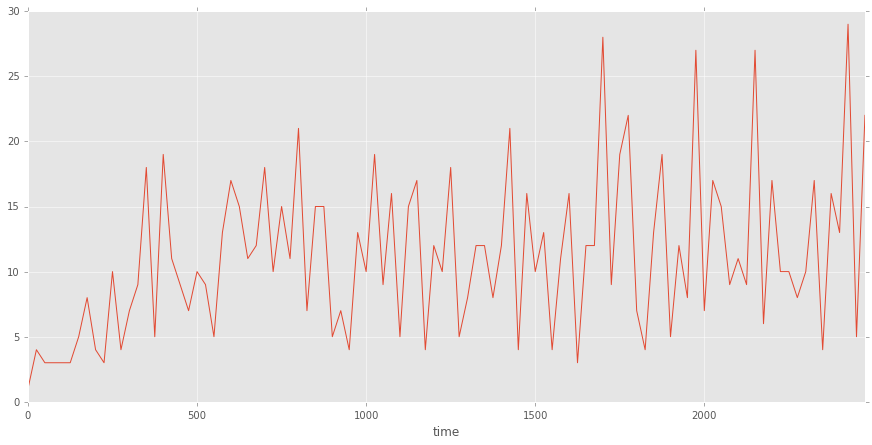

In [18]:
# plot data
fig, axes = plt.subplots(figsize=(15,7))
# use unstack()
ds1.plot(axes=axes)

Obtenemos los valores agregables en los nodos

In [17]:
data_aggregated = data.groupby(by=['time'])['traf_waiting_time','traf_halted_veh_num','emission_co2', 'emission_co', 'emission_hc',
       'emission_noise', 'emission_nox', 'emission_PMx', 'consum_epower','consum_fuel'].sum()
data_aggregated

,traf_waiting_time,traf_halted_veh_num,emission_co2,emission_co,emission_hc,emission_noise,emission_nox,emission_PMx,consum_epower,consum_fuel
time,,,,,,,,,,
0,0.0,1.0,6.016928e+02,6.371561,0.349420,3144.689559,0.839510,0.021261,0.0,0.239886
25,0.0,4.0,2.116541e+05,3942.276680,74.095442,4873.438943,487.272773,30.655817,0.0,84.383320
50,15.0,3.0,2.449908e+05,3845.623672,77.479982,5981.314775,529.534142,27.350811,0.0,97.674295
75,90.0,3.0,2.997103e+05,4496.753497,92.070717,7566.673081,638.717739,31.653822,0.0,119.490193
100,0.0,3.0,4.049616e+05,6049.751801,122.331335,9065.108091,869.521374,44.470928,0.0,161.452413
125,48.0,3.0,5.004670e+05,8200.770329,159.052889,10817.518594,1101.988727,59.863351,0.0,199.528964
150,50.0,5.0,6.328222e+05,9795.766881,192.605666,11944.673491,1360.258457,66.537038,0.0,252.297283
175,192.0,8.0,6.915549e+05,11262.934240,220.268084,13065.973999,1519.933332,82.623137,0.0,275.712929
200,61.0,4.0,7.681760e+05,12017.532160,238.979842,13886.683058,1660.876705,83.878713,0.0,306.260700


In [106]:
data_mean = data.groupby(by=['time'])['traf_travel_time', 'traf_waiting_time',
       'traf_halted_veh_num', 'traf_av_occupancy',
       'traf_av_speed', 'emission_co2', 'emission_co', 'emission_hc',
       'emission_noise', 'emission_nox', 'emission_PMx', 'consum_epower',
       'consum_fuel'].mean()
data_mean

,traf_travel_time,traf_waiting_time,traf_halted_veh_num,traf_av_occupancy,traf_av_speed,emission_co2,emission_co,emission_hc,emission_noise,emission_nox,emission_PMx,consum_epower,consum_fuel
time,,,,,,,,,,,,,
0,56.377276,0.000000,0.000128,7.888619e-07,15.512479,0.076854,0.000814,0.000045,0.401672,0.000107,0.000003,0.0,0.000031
25,38.090607,0.000000,0.000511,2.411225e-04,15.489062,27.034623,0.503548,0.009464,0.622485,0.062239,0.003916,0.0,0.010778
50,16.567912,0.001916,0.000383,3.333327e-04,15.490288,31.292735,0.491202,0.009897,0.763995,0.067638,0.003494,0.0,0.012476
75,25.862002,0.011496,0.000383,6.769515e-04,15.480527,38.282063,0.574371,0.011760,0.966493,0.081584,0.004043,0.0,0.015263
100,7.820139,0.000000,0.000383,8.922610e-04,15.479434,51.725846,0.772736,0.015625,1.157888,0.111064,0.005680,0.0,0.020622
125,19.149719,0.006131,0.000383,1.165274e-03,15.473103,63.924767,1.047486,0.020316,1.381724,0.140757,0.007646,0.0,0.025486
150,23.912303,0.006387,0.000639,6.017970e-03,15.465684,80.830529,1.251216,0.024602,1.525696,0.173746,0.008499,0.0,0.032226
175,46.012921,0.024524,0.001022,2.059989e-03,15.424573,88.332471,1.438617,0.028135,1.668920,0.194141,0.010553,0.0,0.035217
200,23.456250,0.007792,0.000511,1.988923e-03,15.448500,98.119296,1.535002,0.030525,1.773749,0.212144,0.010714,0.0,0.039119


# GARBAGE AND TESTS

In [25]:
data = pd.read_csv('ej1.csv')
data

,ward,division,ballot_type,office,candidate,party,vote_count
0,1,3,A,DISTRICT COUNCIL - 1ST DIST,MARK F SQUILLA,DEMOCRATIC,1
1,1,3,A,DISTRICT COUNCIL - 1ST DIST,Write In,NaN,0
2,1,3,M,DISTRICT COUNCIL - 1ST DIST,MARK F SQUILLA,DEMOCRATIC,65
3,1,3,M,DISTRICT COUNCIL - 1ST DIST,MARK F SQUILLA,DEMOCRATIC,69
4,1,3,M,DISTRICT COUNCIL - 1ST DIST,Write In,NaN,0
5,1,3,M,DISTRICT COUNCIL - 1ST DIST,Write In,NaN,0
6,1,3,P,DISTRICT COUNCIL - 1ST DIST,MARK F SQUILLA,DEMOCRATIC,2
7,1,3,P,DISTRICT COUNCIL - 1ST DIST,Write In,NaN,0


In [50]:
data.groupby(by=['ward', 'division', 'ballot_type', 'office', 'candidate', 'party'])['vote_count'].sum()
print(data)
for d in data:
    print("--> {} = {}".format(d,data[d]))

   ward  division ballot_type                       office       candidate  \
0     1         3           A  DISTRICT COUNCIL - 1ST DIST  MARK F SQUILLA   
1     1         3           A  DISTRICT COUNCIL - 1ST DIST        Write In   
2     1         3           M  DISTRICT COUNCIL - 1ST DIST  MARK F SQUILLA   
3     1         3           M  DISTRICT COUNCIL - 1ST DIST  MARK F SQUILLA   
4     1         3           M  DISTRICT COUNCIL - 1ST DIST        Write In   
5     1         3           M  DISTRICT COUNCIL - 1ST DIST        Write In   
6     1         3           P  DISTRICT COUNCIL - 1ST DIST  MARK F SQUILLA   
7     1         3           P  DISTRICT COUNCIL - 1ST DIST        Write In   

        party  vote_count  
0  DEMOCRATIC           1  
1         NaN           0  
2  DEMOCRATIC          65  
3  DEMOCRATIC          69  
4         NaN           0  
5         NaN           0  
6  DEMOCRATIC           2  
7         NaN           0  
--> ward = 0    1
1    1
2    1
3    1
4    1

In [54]:
df2 = pd.DataFrame([data.groupby(by=['ward', 'division', 'ballot_type'])['vote_count'].mean()])
df2

ward           1           
division       3           
ballot_type    A     M    P
vote_count   0.5  33.5  1.0

In [ ]:

df3=data.groupby(by=['ballot_type'])['vote_count'].mean()
df2 = pd.DataFrame([df3])
df2


In [ ]:
df2.unstack()

In [ ]:
df3

In [ ]:
df3['A']

In [60]:
df3=data.groupby(by=['ballot_type'])['vote_count'].count()

In [61]:
df3

ballot_type
A    2
M    4
P    2
Name: vote_count, dtype: int64

## Draw histograms

In [117]:
#### Function draw_2histograms
# Plots the comparison between two overlapped histograms based on the datasets.
def draw_histogram( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):
    cols = 80
    fig, axes = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.rc('axeses', labelsize=BIG_FONT_SIZE, titlesize=BIG_FONT_SIZE)
    # plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    plt.title("Traveltime Histograms Compared" )
    
    # y_vals1, x_bins1, patches1 = axes.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = axes.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    # [y_vals1, y_vals2], x_bins, patches = axes.hist(travel_times, cols, normed=0, color=['green', 'red'], alpha=0.30, histtype='bar')
    [y_vals1, y_vals2], x_bins, patches = axes.hist(travel_times, cols, normed=0, color=['green', 'red'], histtype='bar', label=['Using TWM','Not using TWM'])
    
    conf_int=0.68
    
    # first histogram ------------------------------------
    x_size1   = len(travel_times1)
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    x_std1    = np.std(travel_times1)
    x_var1    = np.var(travel_times1)
    x_conf_int1  = st.norm.interval(conf_int, loc=x_mean1, scale=x_std1)
    x_m_conf_int1= st.norm.interval(conf_int, loc=x_mean1, scale=x_std1/np.sqrt(x_size1))
    x_shapiro1=st.shapiro(travel_times1)
    x_shapiro_str1 = confidence_str + ("is not normal" if x_shapiro1[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    y_std1    = np.std(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    r_std1    = np.std(ds1['route_path_num'])
    r_var1    = np.var(ds1['route_path_num'])
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_m_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1/np.sqrt(x_size1))
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    # second histogram ------------------------------------
    x_size2   = len(travel_times2)
    x_mean2   = np.mean(travel_times2)
    x_median2 = np.median(travel_times2)
    x_std2    = np.std(travel_times2)
    x_var2    = np.var(travel_times2)
    x_conf_int2  = st.norm.interval(conf_int, loc=x_mean2, scale=x_std2)
    x_m_conf_int2= st.norm.interval(conf_int, loc=x_mean2, scale=x_std2/np.sqrt(x_size2))
    x_shapiro2=st.shapiro(travel_times2)
    x_shapiro_str2 = confidence_str + ("is not normal" if x_shapiro2[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean2   = np.mean(y_vals2)
    y_median2 = np.median(y_vals2)
    y_std2    = np.std(y_vals2)
    r_mean2   = np.mean(ds2['route_path_num'])
    r_median2 = np.median(ds2['route_path_num'])
    r_std2    = np.std(ds2['route_path_num'])
    r_var2    = np.var(ds2['route_path_num'])
    r_conf_int2  = st.norm.interval(conf_int, loc=r_mean2, scale=r_std2)
    r_m_conf_int2= st.norm.interval(conf_int, loc=r_mean2, scale=r_std2/np.sqrt(x_size2))
    r_t_test  = st.ttest_ind( ds1['route_path_num'], ds2['route_path_num'])
    # l_mean2   = np.mean(ds2['route_length'])
    # l_median2 = np.median(ds2['route_length'])
    l_mean2   = 1
    l_median2 = 1
     
    # add a 'best fit' line
    y1_vals2 = np.append( y_vals2, y_vals2[cols-1] )

    x2_mean2   = [ x_mean2   for i in y1_vals2 ]
    x3_median2 = [ x_median2 for i in y1_vals2 ]
    y2_mean2   = [ y_mean2   for i in x_bins ]
    y3_median2 = [ y_median2 for i in x_bins ]

    if( flag_show_demand_stats ):
      theStats = pd.DataFrame([
        [ 'Trips Planned', 'num',  'trips', str_perc(ds_raw1['id'].count(),ds_raw2['id'].count()), ds_raw1['id'].count(), ds_raw2['id'].count()],
        [ 'Trips Routed',  'num',  'trips', str_perc(travel_times1.count(),travel_times2.count()), travel_times1.count(), travel_times2.count()],
        [ 'Trips using TWM',  'num',  'trips', str_perc(travel_times1.count(),len(ds3)), travel_times1.count(), len(ds3)],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTED DEMAND")
      display(HTML(theStats.to_html()))

    if( flag_show_traveltime_stats ):
      theStats = pd.DataFrame([
        [ 'Travel Time', 'mean',  't.units', str_perc(x_mean1,x_mean2), x_mean1, x_mean2 ],
        [ 'Travel Time', 'median',  't.units', str_perc(x_median1,x_median2), x_median1, x_median2 ],
        # [ 'Travel Time', 'variance',  't.units', str_perc(x_var1,x_var2), x_var1, x_var2 ],
        [ 'Travel Time', 'std.deviation',  't.units', str_perc(x_std1,x_std2), x_std1,x_std2 ],
        [ 'Travel Time', 'Value Confidence Interval',  't.units', '', str(x_conf_int1), str(x_conf_int2) ],
        [ 'Travel Time', 'Mean Confidence Interval',  't.units', '', str(x_m_conf_int1), str(x_m_conf_int2) ],
        [ 'Travel Time', 'Shapiro', '', '', x_shapiro_str1, x_shapiro_str2 ]
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]
      print_h2(title, "NON-PAIRED STATS - TRAVELTIME")
      display(HTML(theStats.to_html()))

    if( flag_show_route_stats ):
      theStats = pd.DataFrame([
        [ 'Route Length', 'mean',  'mts', str_perc(r_mean1,r_mean2), r_mean1, r_mean2 ],
        [ 'Route Length', 'median',  'mts', str_perc(r_median1,r_median2), r_median1, r_median2 ],
        # [ 'Route Length', 'variance',  'mts', str_perc(r_var1,r_var2), r_var1, r_var2 ],
        [ 'Route Length', 'std.deviation',  'mts', str_perc(r_std1,r_std2), r_std1, r_std2 ],
        [ 'Route Length', 'Value Confidence Interval',  'mts', '', str(r_conf_int1), str(r_conf_int2) ],
        [ 'Route Length', 'Mean Confidence Interval',  'mts', '', str(r_m_conf_int1), str(r_m_conf_int2) ],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTE LENGTH")
      display(HTML(theStats.to_html()))

    print_h2(title, "NON-PAIRED STATS - TRAVELTIMES COMPARED HISTOGRAM")
    if ( flag_print_histogram_shape ):
        line_estimation1 = axes.plot(x_bins, y1_vals1, 'r-', label='Estimation', linewidth=2, color='darkgreen')
        line_estimation2 = axes.plot(x_bins, y1_vals2, 'r-', label='Estimation', linewidth=2, color='darkred')

    maxes_y = np.linspace(0, maxes( maxes(y_vals1), maxes(y_vals2)), num=len(x_bins))
    line_mean1 = axes.plot(x2_mean1, maxes_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = axes.plot(x3_median1, maxes_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    line_mean2 = axes.plot(x2_mean2, y1_vals2, label='Mean', linestyle='--', linewidth=2, color='darkred')
    line_median2 = axes.plot(x3_median2, maxes_y, label='Median', linestyle='-', linewidth=2, color='darkred')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label='Mean: '+label1)
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label='Median: '+label1)
    mean_line2   = mlines.Line2D([], [], linestyle='--',color='darkred',  markersize=1, label='Mean: '+label2)
    median_line2 = mlines.Line2D([], [], linestyle='-', color='darkred',  markersize=1, label='Median: '+label2)
    red_patch = mpatches.Patch(color='red', label='Using TWM')
    green_patch = mpatches.Patch(color='green', label='Not using TWM')
    axes.legend(handles=[red_patch, green_patch, median_line1, mean_line1, median_line2, mean_line2], loc='upper right', fancybox=True, framealpha=0.5)
    plt.rc('legend', fontsize=MID_FONT_SIZE)
    # plt.axesis([travel_times.min(), travel_times.maxes()+1, 0, 0.03])
    axes.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

In [4]:
df = pd.DataFrame({
    'name':['john','mary','peter','jeff','bill','lisa','jose'],
    'age':[23,78,22,19,45,33,20],
    'gender':['M','F','M','M','M','F','M'],
    'state':['california','dc','california','dc','california','texas','texas'],
    'num_children':[2,0,0,3,2,1,4],
    'num_pets':[5,1,0,5,2,2,3]
})
df[['name','age','gender','state','num_children','num_pets']]

,name,age,gender,state,num_children,num_pets
0,john,23,M,california,2,5
1,mary,78,F,dc,0,1
2,peter,22,M,california,0,0
3,jeff,19,M,dc,3,5
4,bill,45,M,california,2,2
5,lisa,33,F,texas,1,2
6,jose,20,M,texas,4,3


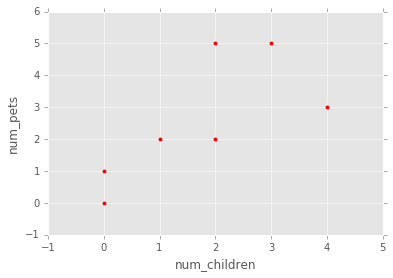

In [5]:
# plot num_children vs num_pets
df.plot(kind='scatter',x='num_children',y='num_pets',color='red')